## 信号建模与算法实践实验一：音频信号FMCC特征分析
#### PB19071509 王瑞哲

> 导入必要包与函数定义

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import wavfile
from scipy.fftpack import dct

from utils import tdraw,fdraw,gdraw

> 导入音频信号。先导入1.wav

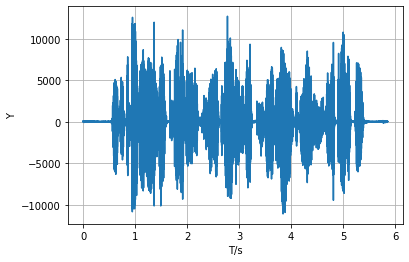

In [2]:
sample_rate, s = wavfile.read('./1.wav')
tdraw(s, sample_rate)

> 绘制原信号的傅里叶频谱图

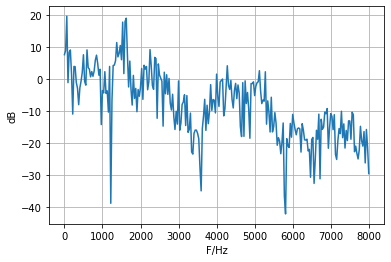

In [3]:
fdraw(s, sample_rate)

> 预加重：放大高频，使用一阶滤波器$y(t) = x(t) - \alpha x(t-1), \ \ \ \  0.95 < \alpha < 0.99$，并选择$\alpha=0.97$

In [4]:
alpha = 0.97
s = np.append(s[0], s[1:] - alpha * s[:-1])

> 成帧：帧长为 25ms，帧移为 10ms（重叠 15ms）

In [5]:
frame_size, frame_stride = 0.025, 0.01
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
signal_length = len(s)
num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

pad_signal_length = (num_frames - 1) * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(s, z)

indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
frames = pad_signal[indices]

> 加窗：选择汉明hamming窗$w(n) = 0.54 - 0.46 cos(\frac{2\pi n}{N-1})$

In [6]:
hamming = np.hamming(frame_length)
frames *= hamming

> 快速傅里叶变换与功率谱计算

In [7]:
N = 512
mag_frames = np.absolute(np.fft.rfft(frames, N))
pow_frames = ((1.0 / N) * (mag_frames ** 2))

> 滤波器组与FBANK特征

In [8]:
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
nfilt = 40  # 通常设置成40个滤波器
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 所有的mel中心点，为了方便后面计算mel滤波器组，左右两边各补一个中心点
hz_points = 700 * (10 ** (mel_points / 2595) - 1)
fbank = np.zeros((nfilt, int(N / 2 + 1)))  # 各个mel滤波器在能量谱对应点的取值
bin = (hz_points / (sample_rate / 2)) * (N / 2)  # 各个mel滤波器中心点对应FFT的区域编码，找到有值的位置
for i in range(1, nfilt + 1):
    left = int(bin[i-1])
    center = int(bin[i])
    right = int(bin[i+1])
    for j in range(left, center):
        fbank[i-1, j+1] = (j + 1 - bin[i-1]) / (bin[i] - bin[i-1])
    for j in range(center, right):
        fbank[i-1, j+1] = (bin[i+1] - (j + 1)) / (bin[i+1] - bin[i])

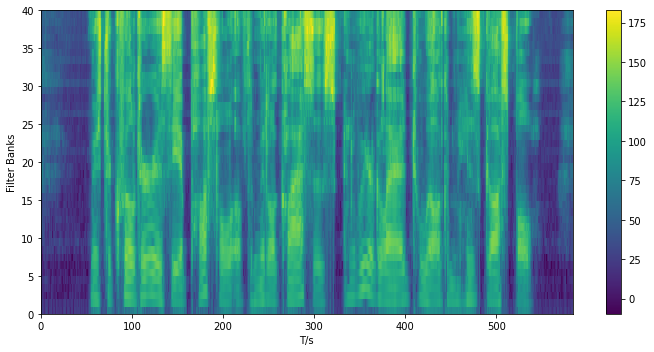

In [9]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB
gdraw(filter_banks.T, 'Filter Banks')

> MFCC特征

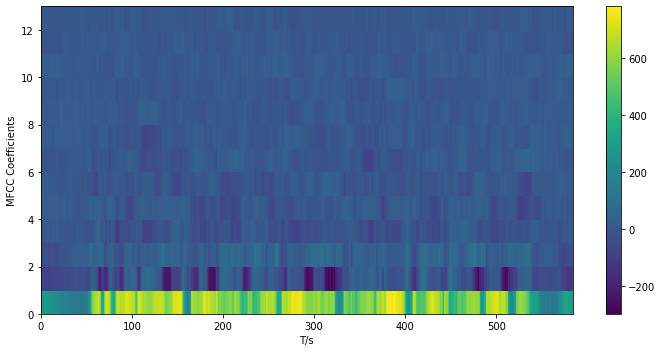

In [10]:
num_ceps = 13    # 选取前13维
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 0:num_ceps]   # 切片操作左闭右开
np.save("mfcc_wav1.npy", mfcc)    # 存储最终的特征文件
gdraw(mfcc.T, 'MFCC Coefficients')

> 2.wav运行耗时分析

Processing '2.wav' cost 8.673s


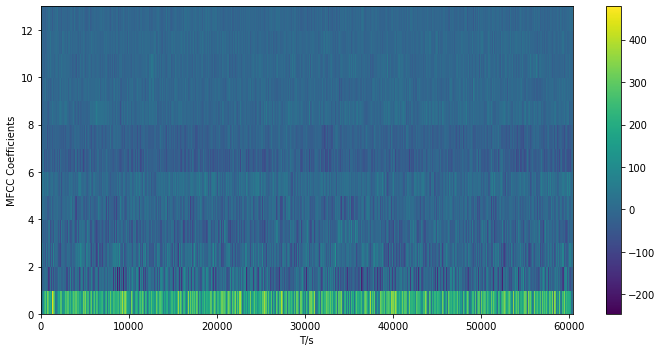

In [11]:
import time

t0 = time.time()

# 导入音频
sample_rate, s = wavfile.read('./2.wav')
# 预加重
alpha = 0.97
s = np.append(s[0], s[1:] - alpha * s[:-1])
# 成帧
frame_size, frame_stride = 0.025, 0.01
frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
signal_length = len(s)
num_frames = int(np.ceil(np.abs(signal_length - frame_length) / frame_step)) + 1

pad_signal_length = (num_frames - 1) * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(s, z)

indices = np.arange(0, frame_length).reshape(1, -1) + np.arange(0, num_frames * frame_step, frame_step).reshape(-1, 1)
frames = pad_signal[indices]
# 加窗
hamming = np.hamming(frame_length)
frames *= hamming
# FFT计算
N = 512
mag_frames = np.absolute(np.fft.rfft(frames, N))
pow_frames = ((1.0 / N) * (mag_frames ** 2))
# FBANK特征计算
low_freq_mel = 0
high_freq_mel = 2595 * np.log10(1 + (sample_rate / 2) / 700)
nfilt = 40  # 通常设置成40个滤波器
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # 所有的mel中心点，为了方便后面计算mel滤波器组，左右两边各补一个中心点
hz_points = 700 * (10 ** (mel_points / 2595) - 1)
fbank = np.zeros((nfilt, int(N / 2 + 1)))  # 各个mel滤波器在能量谱对应点的取值
bin = (hz_points / (sample_rate / 2)) * (N / 2)  # 各个mel滤波器中心点对应FFT的区域编码，找到有值的位置
for i in range(1, nfilt + 1):
    left = int(bin[i-1])
    center = int(bin[i])
    right = int(bin[i+1])
    for j in range(left, center):
        fbank[i-1, j+1] = (j + 1 - bin[i-1]) / (bin[i] - bin[i-1])
    for j in range(center, right):
        fbank[i-1, j+1] = (bin[i+1] - (j + 1)) / (bin[i+1] - bin[i])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
filter_banks = 20 * np.log10(filter_banks)  # dB
# MFCC特征计算
num_ceps = 13    # 选取前13维
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 0:num_ceps]   # 切片操作左闭右开
np.save("mfcc_wav2.npy", mfcc)    # 存储最终的特征文件
gdraw(mfcc.T, 'MFCC Coefficients')

t1 = time.time()
print("Processing \'2.wav\' cost {:.3f}s".format(t1-t0))